<h1 align='center'> Customer Churn Prediction </h1>

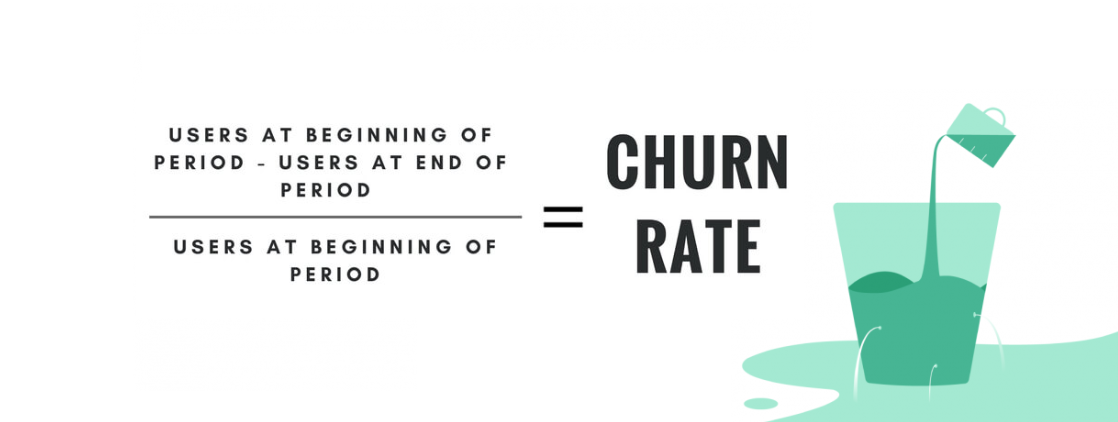

<b> What is churn rate? </b>

The churn rate measures the rate at which people stop doing business or stop working with a company. It is most commonly expressed as the percentage of service subscribers who discontinue their subscriptions within a given time period, but it can also measure the rate at which employees leave their jobs within a certain period.


<b> Why is it important to know? </b>

The churn rate is a critical metric for customer satisfaction and for measuring growth, as it tells you how many existing customers are leaving your business. By managing to lower the churn rate by anticipating which customers are in the verge of leaving, we can have an impact on the business revenues and growth potential. Predicting the customer churn is especially important for Software as a Service (SaaS) business models or similar business models that have a subscription- and membership-based customers that use the services of a company frequently, but are in a sector where there are other companies that offer similar services, so predicting the customer satisfaction through the customer churn becomes a critical factor in order to succeed.

## Outline for Customer Churn Prediction

1. Framing the Problem
2. Exploratory Data Analysis
3. Feature Engineering
4. Exploring Different Models
5. Fine-tuning the Best Models
6. Drawing Conclusions

<b> Scenario </b>

The data comes from the IBM Developer Platform, where we have a  telecommunications company called Telco that has tracked its customers whether they left their services within the last month, and different features of the customers such as demographics, type of service and customer account information. The marketing manager wants to know who would be the people we should target with our marketing campaign so that we would be able to retain as many subscribers as possible within our services, as it is much cheaper to retain old customers than gain new ones. 

Moreover, we are told that each customer brings on average €780 revenues per year and we would be able to retain around half of the customers that are on the verge of leaving with a targeted promotion that would bring on average €500 on revenue per year if we manage to track these specific people in time by the end of the month. This means, we would be willing to give a reduction of price for the next year's subscription if the customer decides to stay.

## 1. Framing the problem

As we are looking for people who are either paying or not paying for the service, this will be a binary classification problem. However, the fact that we want to find especially the people who might leave the service makes the problem an unbalanced classification problem where knowing the people who want to leave is more valuable than knowing the people that want to stay. There are three ways to tackle this issue:

- By focusing on the Sensitivy (i.e. Recall) of the results. We would be interested to know how relevant our findings are compared to the total number of people that would be leaving our service. Here, we would be comparing the people classified as true positives to  all the people that should be identified correctly (i.e. true positives + false negatives).

- Increasing the cost of the minority class. By setting a penalty for misclassificating the minority class (i.e. people on the verge of leaving) we should be able to classify this class more accurately. 

- Oversampling the minority class. By giving proportionally a larger size of those people that are leaving the service for the model to train, it should become better at classifying the people more accurately.


This also means that we are prepared to accept a few mistakes in classifying some of the customers wrongly and giving those people some additional benefits for membership fee reductions in order to maximize the revenue that we would get by making sure we manage to find the maximum amount of people in the verge of leaving our service. 

In [96]:
# Importing relevant modules

import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# tools for modeling

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

# plot styling preferences
plt.style.use('seaborn-whitegrid')

font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 12, 6

## 2. Exploratory data analysis

<b> Getting and preparing the data

In [2]:
# Loading data

df = pd.read_csv('data/customer_churn_data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Checking for missing values 

df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

We have three quantitative categories of variables and the rest seem to be objects. However, the TotalCharges should probably be a float so we need to check why this isn't the case.

In [5]:
df['TotalCharges'].value_counts()

20.2       11
           11
19.75       9
19.9        8
19.65       8
           ..
261.25      1
1653.85     1
6171.2      1
5175.3      1
4539.6      1
Name: TotalCharges, Length: 6531, dtype: int64

We notice that there are 11 cases where the empty values appear to be stored as empty spaces.

In [6]:
df[df['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Before we can transform the category into a numerical float we need to find a way to deal with the missing values. There are several ways to deal with this issue, starting from dropping the rows to filling the missing cells with values such as the mean, median or mode value from that column. However, as we have over 7000 samples of data and as these people who have missing total charges are indicated with a negative churn, they are not so valuable for us, and hence, we can just drop these rows altogether. 

In [7]:
# Dropping customers with missing values and converting total charges as float

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


Now the data looks good so we can start visualizing the different variables to see if we could see some patterns arising.

<b> Visualizing the data </b>

We will first start with the numerical variables and visualize them first their distributions and then compare the variables with the binary churn variable.

We can see that the minority of our customers (1 in 6) consists of senior citizens. If these people are on the verge of quitting the service, it might be beneficial to distinguish these from the other customers due to the fact that elderly people usually prefer to talk to someone rather than read something from en email.

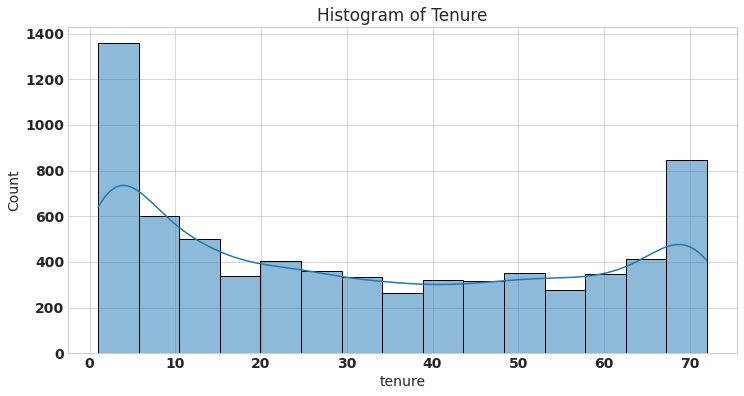

In [621]:
# Plotting histogram of tenure

sns.histplot(x=df['tenure'], kde=True)
plt.title('Histogram of Tenure')
plt.show()

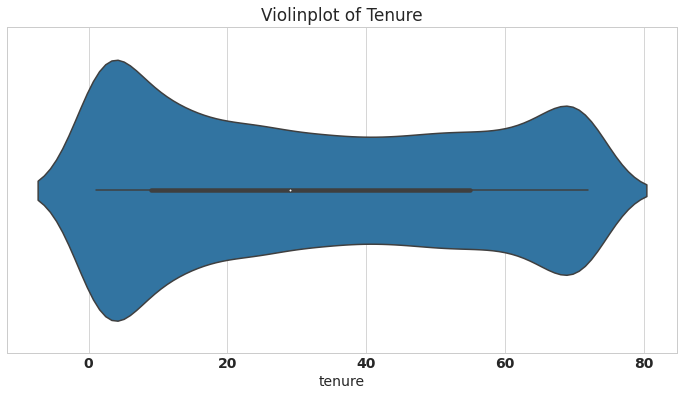

In [622]:
# Plotting violinplot of tenure

sns.violinplot(x=df['tenure'])
plt.title('Violinplot of Tenure')
plt.show()

The tenure indicates how many months each customer has stayed with the service. We can see that there are two clear peaks in the distribution: new customers that have joined the service recently and long-term customers who have stayed in already for a while. From the violinplot we can see that the median is around 30 months with a concentration of more people that are new to the service. Knowing this information would also be inportant once we contact a customer that is on the verge of quitting the service and tailor our message.

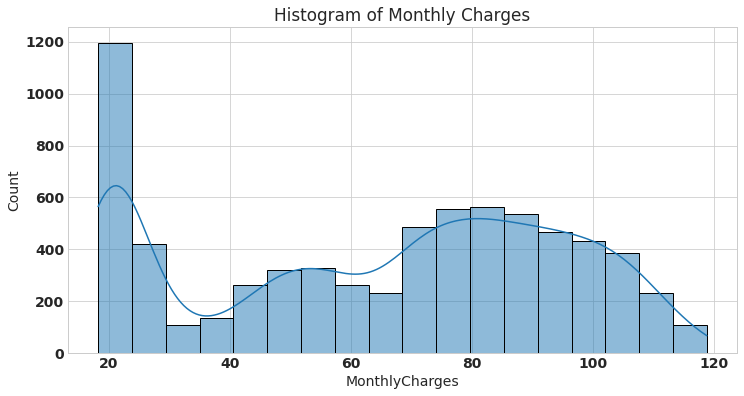

In [623]:
# Plotting histogram of monthly charges

sns.histplot(x=df['MonthlyCharges'], kde=True)
plt.title('Histogram of Monthly Charges')
plt.show()

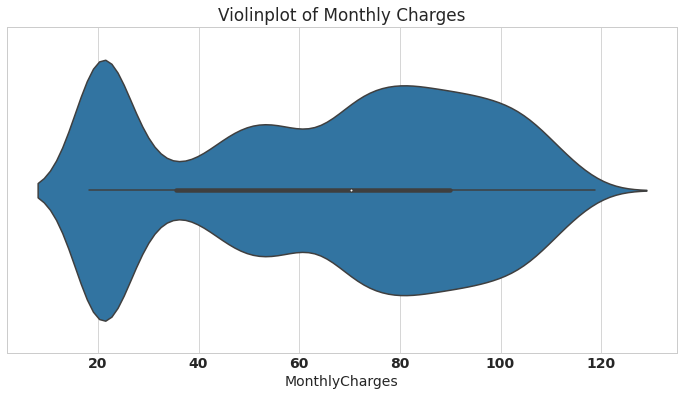

In [624]:
# Plotting violinplot of monthly charges

sns.violinplot(x=df['MonthlyCharges'])
plt.title('Violinplot of Monthly Charges')
plt.show()

From the two plots we can see that the highest number of customers have a monthly bill of around €20. However, we can also see from the surface area that the majority of people fall between 40 and 120 euros in monthly charges. The violinplot also shows that the median (i.e. white dot) is around €70, with a bit higher concentration of customers paying less than the median (i.e. black line). 

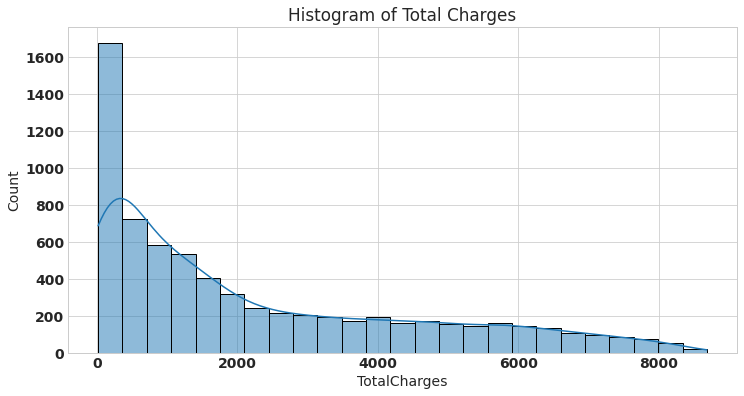

In [625]:
# Plotting histogram of total charges

sns.histplot(x=df['TotalCharges'], kde=True)
plt.title('Histogram of Total Charges')
plt.show()

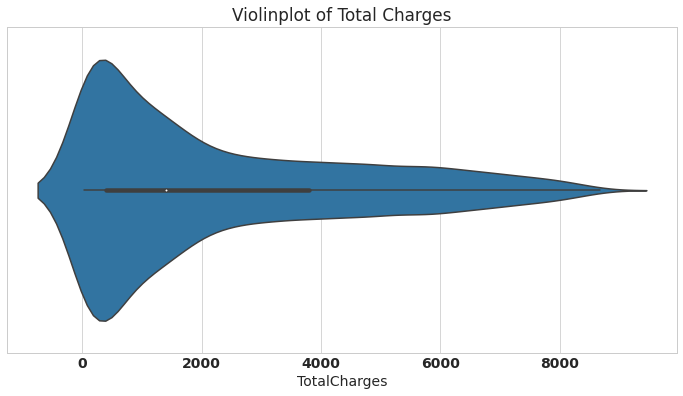

In [626]:
# Plotting violinplot of total charges

sns.violinplot(x=df['TotalCharges'])
plt.title('Violinplot of Total Charges')
plt.show()

In [595]:
# Range of total charges

print('The minimum of total charges is €{}'.format(round(df['TotalCharges'].min())))
print('The maximum of total charges is €{}'.format(round(df['TotalCharges'].max())))
print('The median of total charges is €{}'.format(round(np.median(df['TotalCharges']))))

The minimum of total charges is €19
The maximum of total charges is €8685
The median of total charges is €1397


There seems to be quite a difference how much the people are paying for their services, ranging from 19€ to €8685 with a median of around €1400. This makes a big difference to know as some customers are much more valuable than others. 

Next we plot the churn rates and then make the comparison to the previous variables.

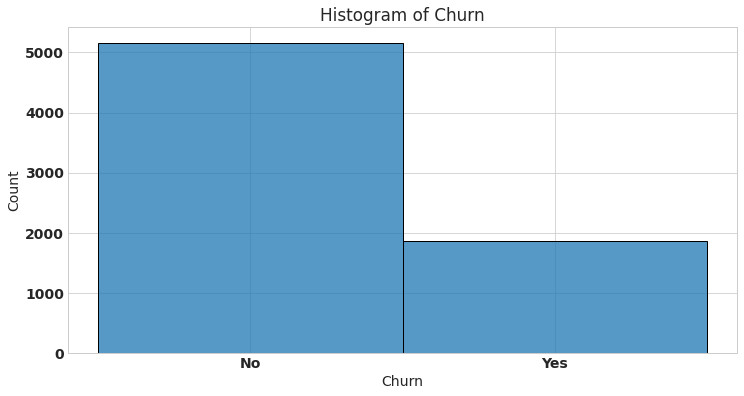

In [627]:
# Plotting histogram of churn rate

sns.histplot(x=df['Churn'])
plt.title('Histogram of Churn')
plt.show()

In [597]:
# Checking value counts of churn

df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [598]:
# Calculating churn rate from the dataset

(1869/(1869+5163))*100

26.578498293515356

From the 7000 customers that are in the dataset, the majority of the customers seem to indicate of staying with the service where 1 out of 4 customers have left the service.

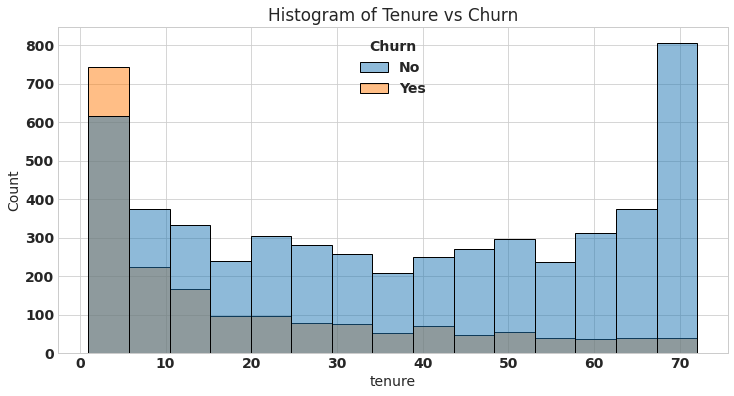

In [628]:
# Plotting tenure with churn

sns.histplot(x='tenure', data=df, hue='Churn', hue_order=['No','Yes'], stat='count')
plt.title('Histogram of Tenure vs Churn')
plt.show()

The histogram shows clearly that most of the people that decide to churn are the ones that haven't used the service for a very long time. In fact, the highest amount of people quit at the first month of subscription. As more time passes, people become more locked into not leaving the service.

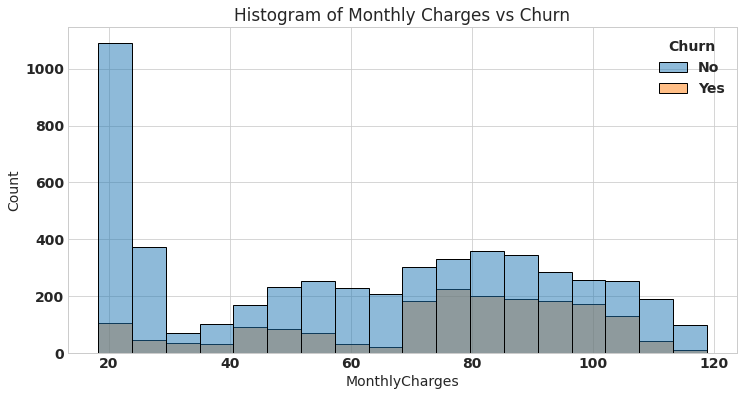

In [629]:
# Plotting monthly charges with churn

sns.histplot(data=df, x='MonthlyCharges', hue='Churn', hue_order=['No','Yes'], stat='count')
plt.title('Histogram of Monthly Charges vs Churn')
plt.show()

We can see from the monthly charges that as the charges go up people are more tempted to opt out from the subscription.

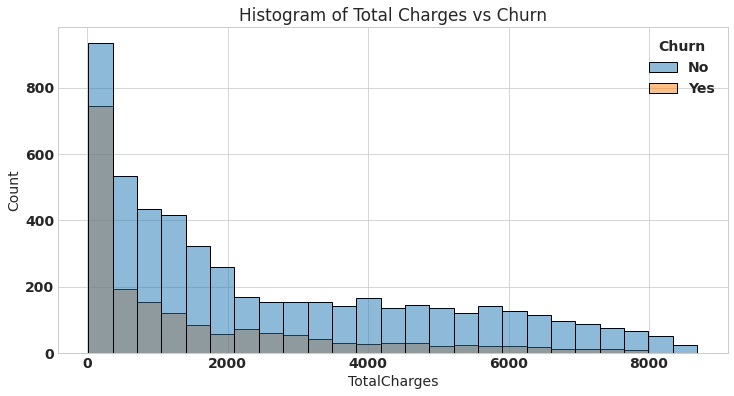

In [630]:
# Plotting histogram of total charges with churn

sns.histplot(data=df, x='TotalCharges', hue='Churn', hue_order=['No','Yes'], stat='count')
plt.title('Histogram of Total Charges vs Churn')
plt.show()

The total charges seem to affect the opposite way as before, as the lower the total charges, the higher the tendency to churn. People quite the service right at the beginning of the subscription when the total charges haven't accumulated much and we can see this tendency to drop after charges start rising from €2,000.

We have found now three features which clearly affects churn so we take note and continue by visualizing the demographic features of the dataset.

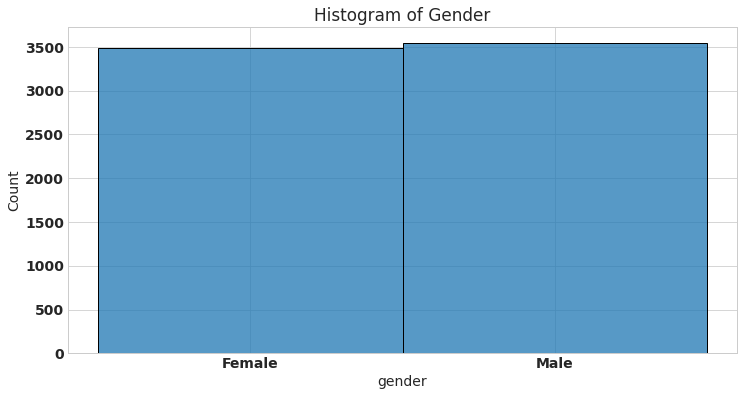

In [632]:
# plotting histogram of gender

sns.histplot(x=df['gender'], bins=2, discrete=True)
plt.title('Histogram of Gender')
plt.show()

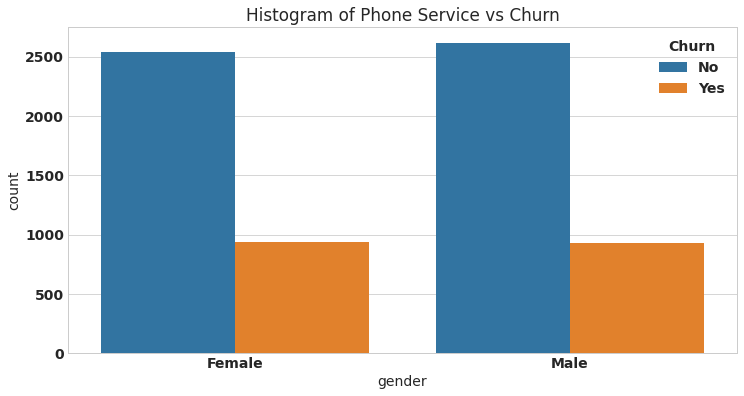

In [633]:
# Plotting gender with churn

sns.countplot(x='gender', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Phone Service vs Churn')
plt.show()

The histogram of the gender looks balanced as well once we plot it together with the decision to quite the subscription.

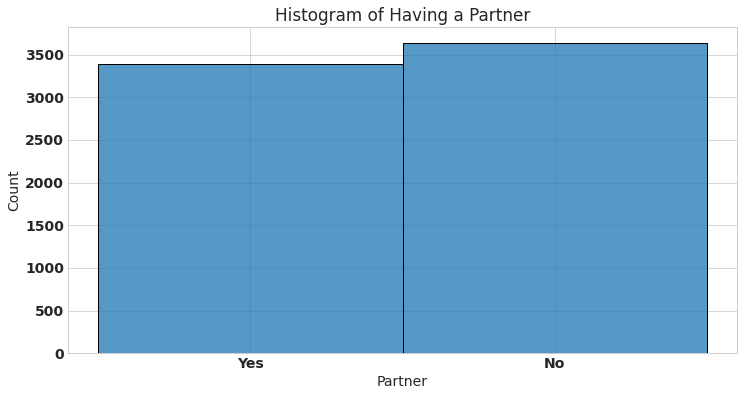

In [634]:
# Plotting histogram of having a partner

sns.histplot(x=df['Partner'], bins=2, discrete=True)
plt.title('Histogram of Having a Partner')
plt.show()

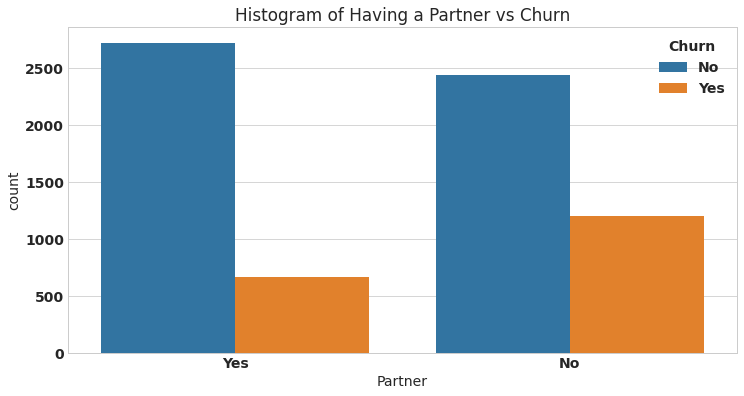

In [635]:
# Plotting partner with churn

sns.countplot(x='Partner', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Having a Partner vs Churn')
plt.show()

Both plots look again quite well balanced and there isn't any clear pattern to be noticed.

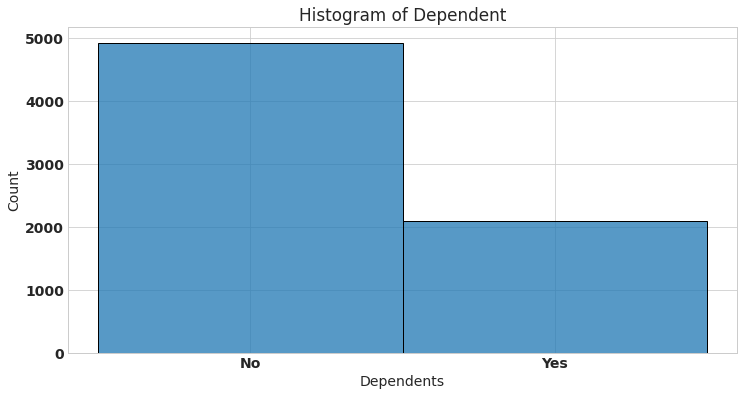

In [636]:
# Plotting histogram of customer being dependent

sns.histplot(x=df['Dependents'], bins=2, discrete=True)
plt.title('Histogram of Dependent')
plt.show()

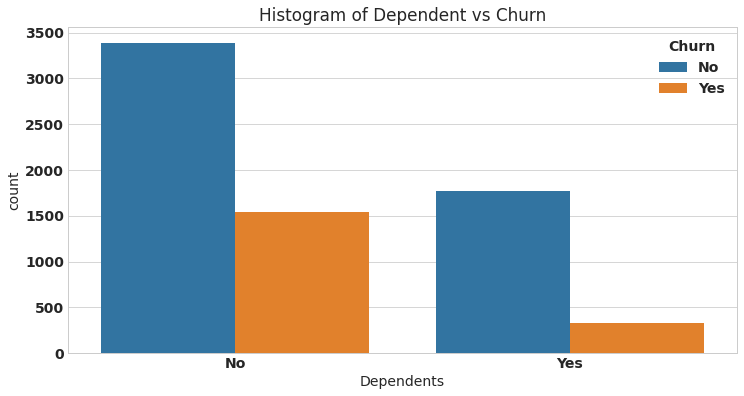

In [637]:
# Plotting being dependent with churn

sns.countplot(x='Dependents', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Dependent vs Churn')
plt.show()

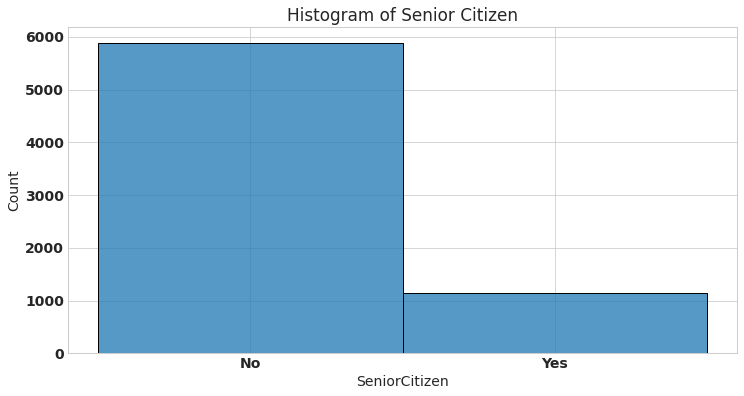

In [642]:
# Plotting histogram of senior citizen

sns.histplot(x=df['SeniorCitizen'], bins=2, discrete=True)
plt.title('Histogram of Senior Citizen')
plt.xticks(ticks=(0,1), labels=['No','Yes'])
plt.show()

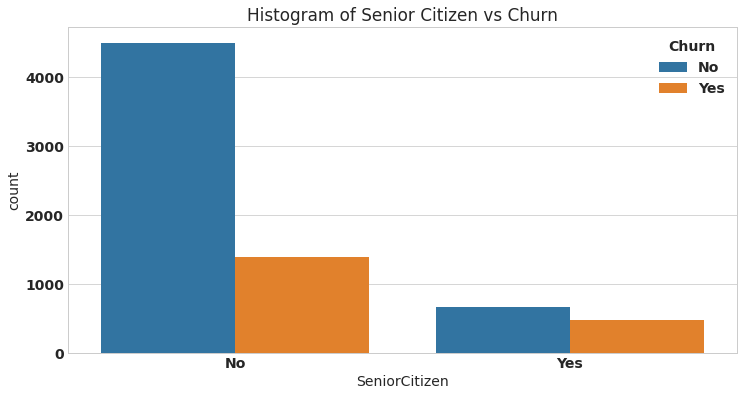

In [644]:
# Plotting senior citizen with churn

sns.countplot(x='SeniorCitizen', data=df, hue='Churn', hue_order=['No','Yes'])
plt.xticks(ticks= (0,1), labels=['No','Yes'])
plt.title('Histogram of Senior Citizen vs Churn')
plt.show()

The histograms of whether the customer is dependent or a senior citizen look similar. However, a closer look at the decisions these people make concerning the churn we notice that the majority of the senior citizens seem to be opting to cancel their subscription. This group also consists of around 1/4 all to the people who cancel out in the dataset which makes this group something that should be looked closer for the possible reasons this is happening.

After the demographic variables we turn to the type of services the customers have subscribed to.

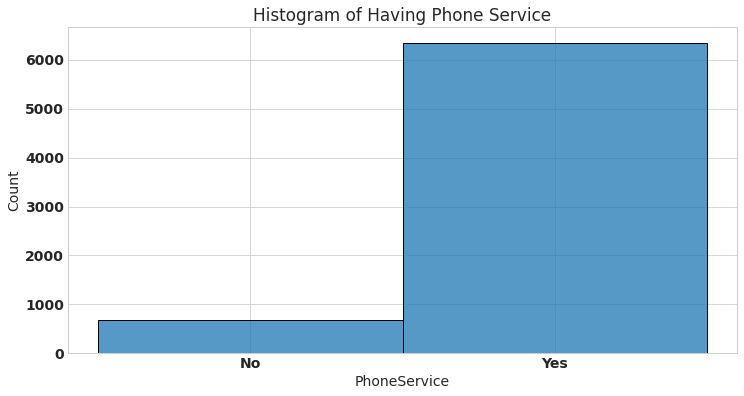

In [643]:
# Plotting histogram of having phone service

sns.histplot(x=df['PhoneService'], bins=2, discrete=True)
plt.title('Histogram of Having Phone Service')
plt.show()

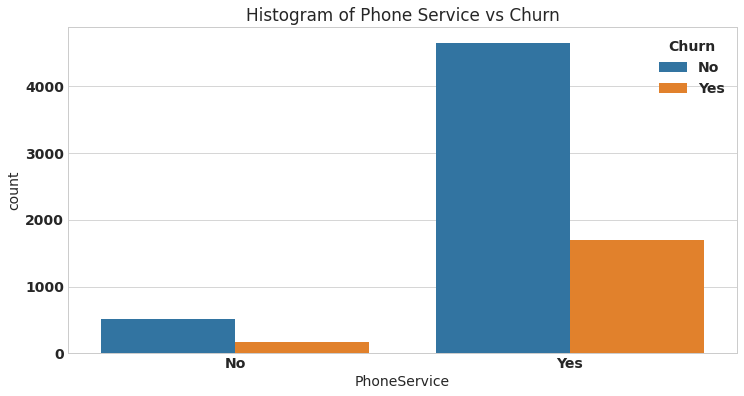

In [645]:
# Plotting having phone service with churn

sns.countplot(x='PhoneService', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Phone Service vs Churn')
plt.show()

Most of the customers have a phone service and it doesn't seem to affect the decision to quite the service.

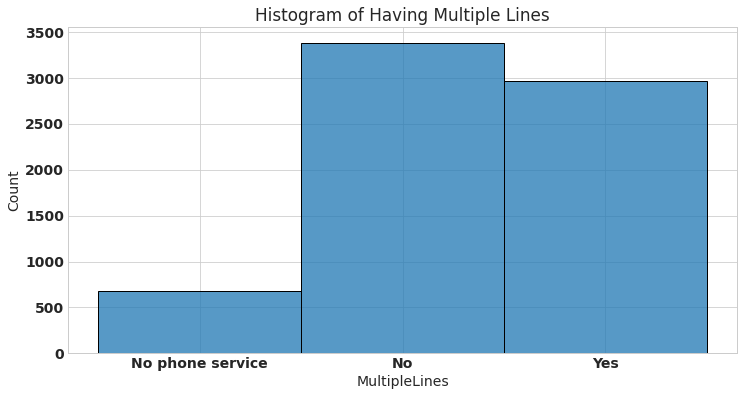

In [646]:
# Plotting histogram of having multiple lines

sns.histplot(x=df['MultipleLines'], bins=3, discrete=True)
plt.title('Histogram of Having Multiple Lines')
plt.show()

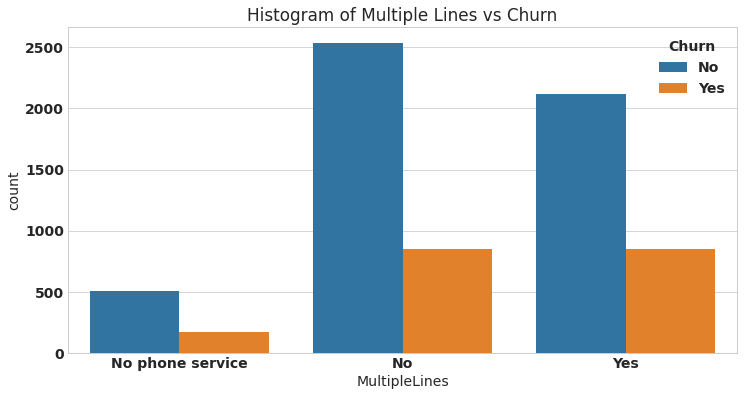

In [647]:
# Plotting having multiple lines with churn

sns.countplot(x='MultipleLines', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Multiple Lines vs Churn')
plt.show()

Around half of the customers enjoy having multiple lines and this has a minor affect on the churn being proportionally slightly higher for those that have multiple lines compared to those that don't have or those with no phone service.

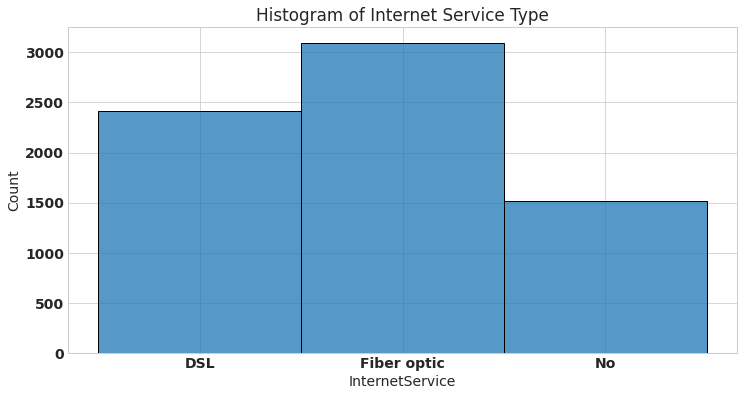

In [648]:
# Plotting histogram of internet service type

sns.histplot(x=df['InternetService'], bins=3, discrete=True)
plt.title('Histogram of Internet Service Type')
plt.show()

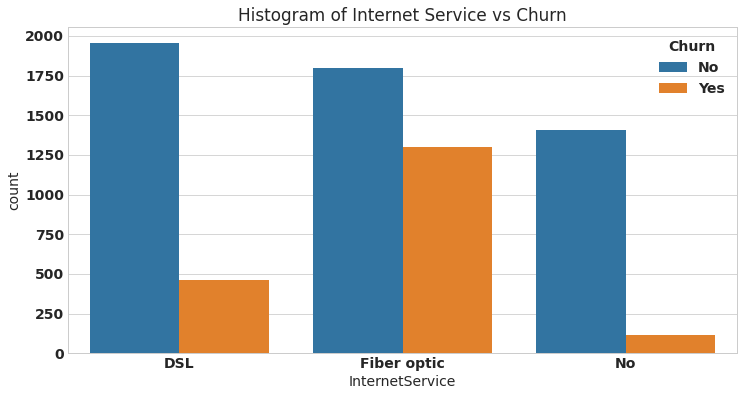

In [649]:
# Plotting internet service type with churn

sns.countplot(x='InternetService', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Internet Service vs Churn')
plt.show()

The majority of the customers seem to have fiber optic and most of these people decide to quit the subscription. We will make a note of this and continue to the next variable.

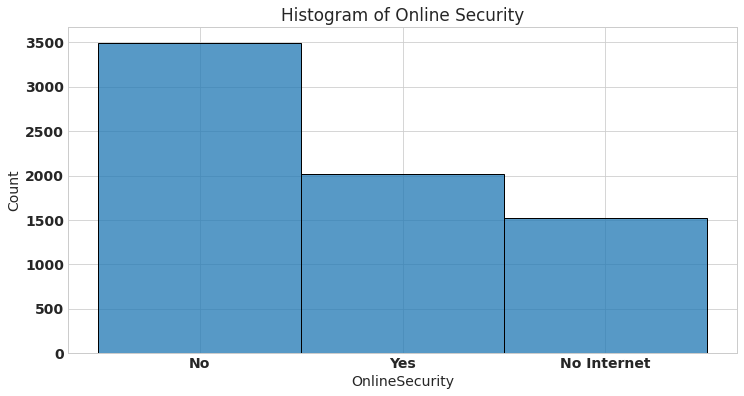

In [650]:
# Plotting histogram of having online security
sns.histplot(x=df['OnlineSecurity'], bins=3)
plt.title('Histogram of Online Security')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

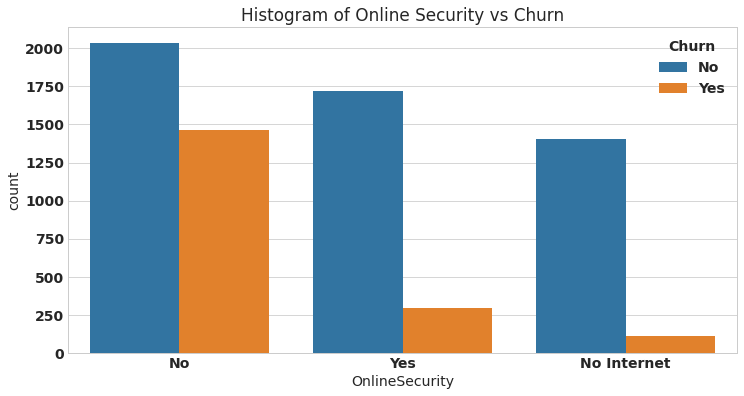

In [651]:
# Plotting having online security with churn 

sns.countplot(x='OnlineSecurity', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Online Security vs Churn')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

The majority of the people don't have online security option selected and from these people a high number of people decide to leave the service. This is something that should be looked closer.

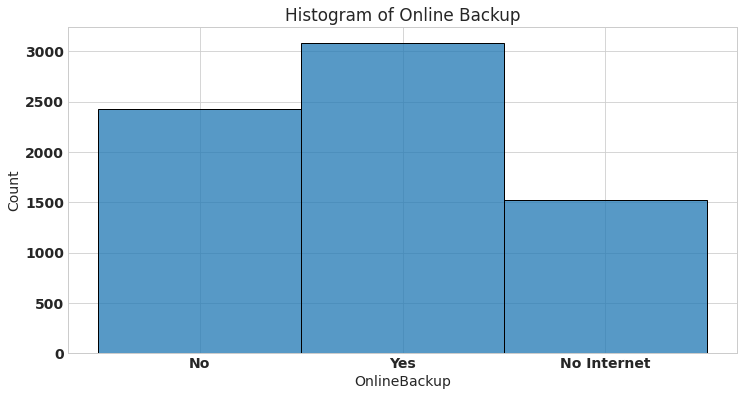

In [652]:
# Plotting histogram of having online backup

sns.histplot(x=df['OnlineBackup'], bins=3)
plt.title('Histogram of Online Backup')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

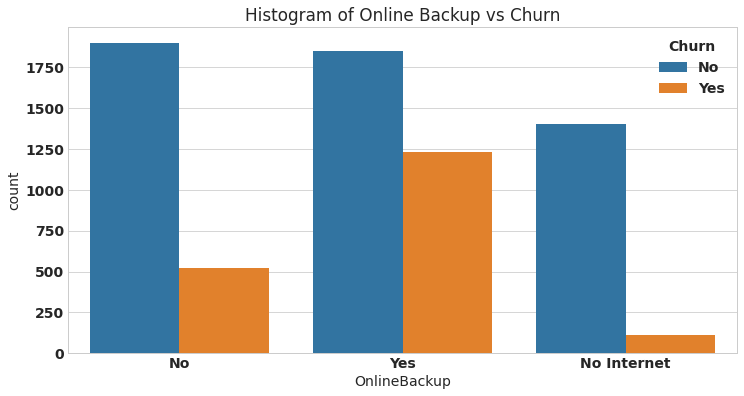

In [653]:
# Plotting having online backup with churn

sns.countplot(x='OnlineBackup', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Online Backup vs Churn')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

The majority of the customers have online backup option chosen and these people also tend to quite the subscription so we have yet another variable that clearly affects churn. We take note and proceed to the next variable.

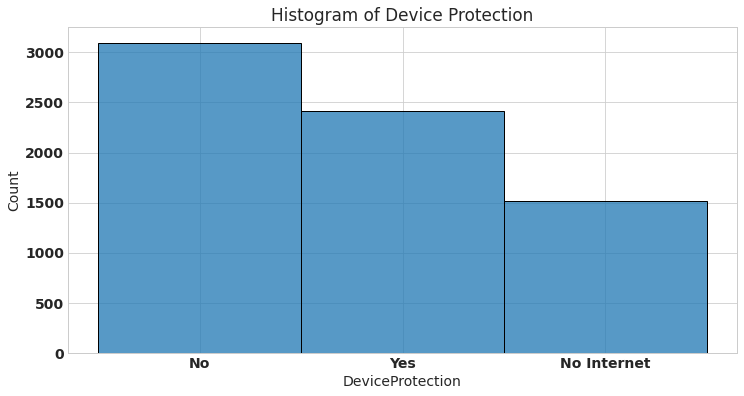

In [654]:
# Plotting histogram of having device protection

sns.histplot(x=df['DeviceProtection'], bins=3)
plt.title('Histogram of Device Protection')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

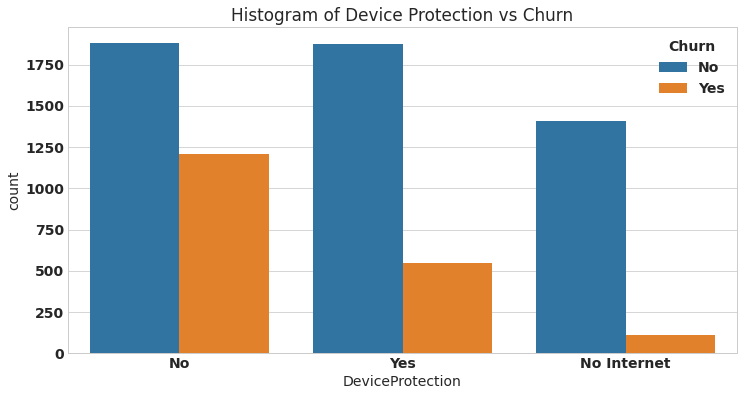

In [655]:
# Plotting having device protection with churn

sns.countplot(x='DeviceProtection', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Device Protection vs Churn')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

The majority of the customers do not have their device protected by the service and these people also tend to quit the subscription, so we take again note of this.

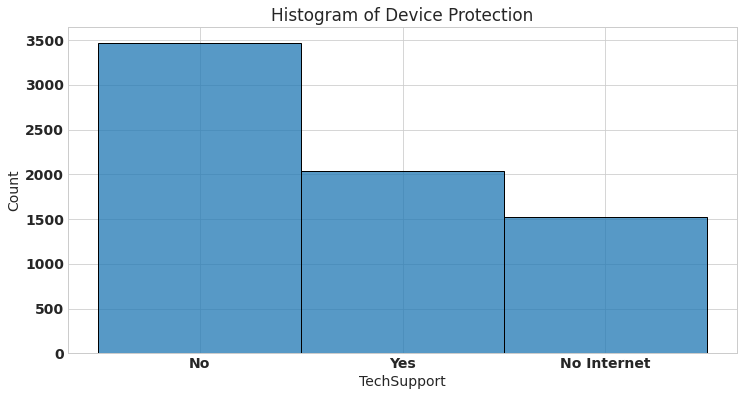

In [656]:
# Plotting histogram of having tech support

sns.histplot(x=df['TechSupport'], bins=3)
plt.title('Histogram of Device Protection')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

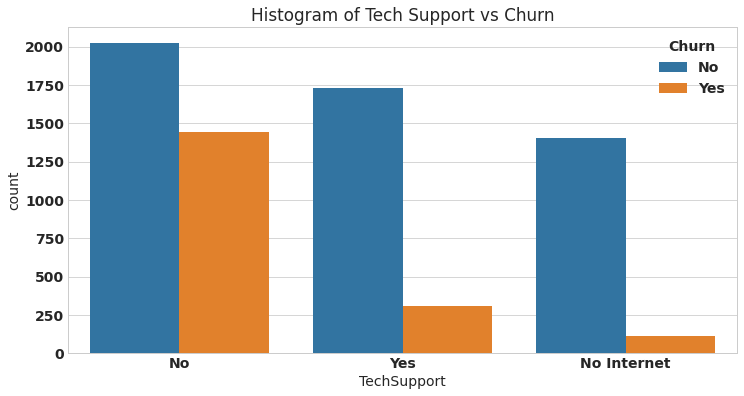

In [657]:
# Plotting having tech support with churn

sns.countplot(x='TechSupport', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Tech Support vs Churn')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

The majority of the customers do not have tech support chosen as their option either and the same people also tend to quit the subscription more frequently than the others, so take note and continue our analysis.

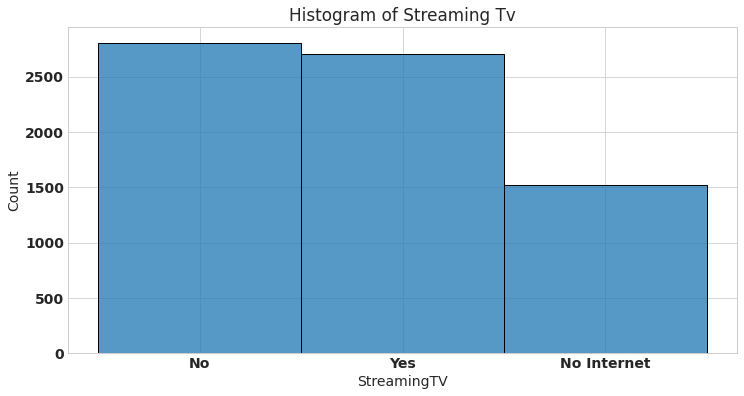

In [658]:
# Plotting histogram of having streaming tv

sns.histplot(x=df['StreamingTV'], bins=3)
plt.title('Histogram of Streaming Tv')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

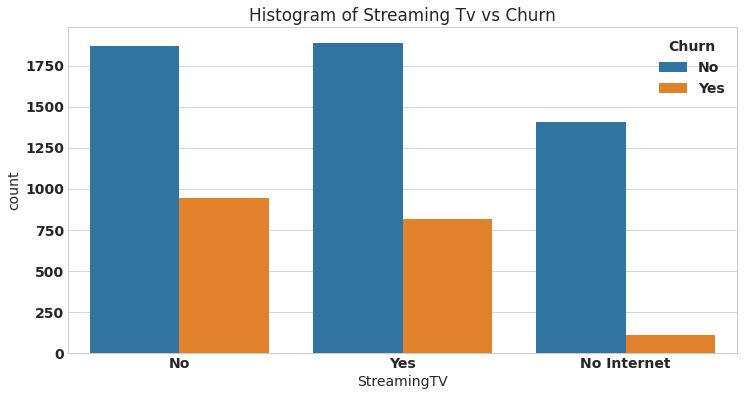

In [659]:
# Plotting having streaming tv with churn

sns.countplot(x='StreamingTV', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Streaming Tv vs Churn')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

The two figures look quite balanced with no clear pattern emerging on neither of them.

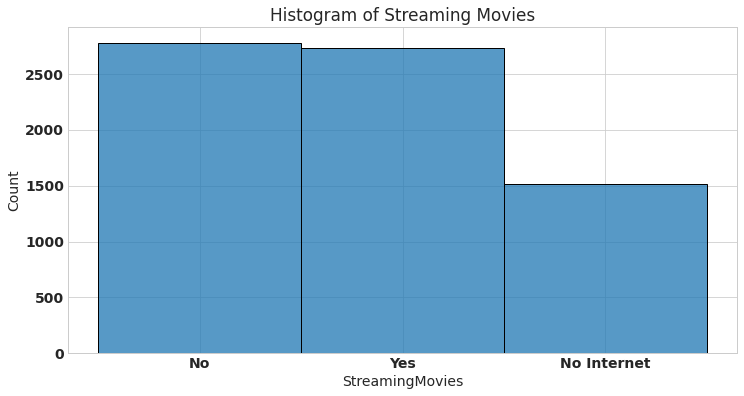

In [660]:
# Plotting histogram of having streaming movies

sns.histplot(x=df['StreamingMovies'], bins=3)
plt.title('Histogram of Streaming Movies')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

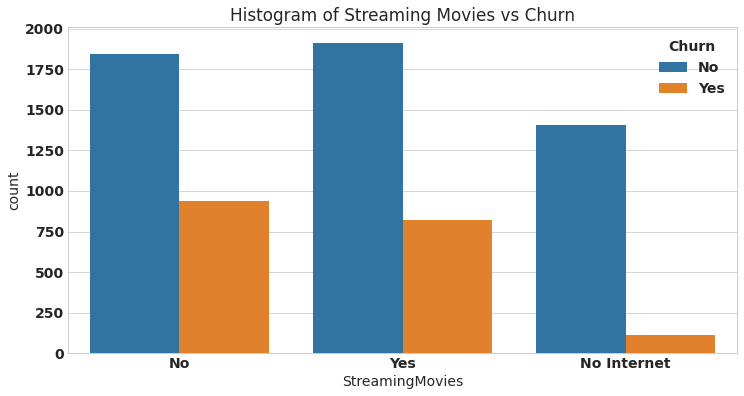

In [661]:
# Plotting having streaming movies with churn

sns.countplot(x='StreamingMovies', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Streaming Movies vs Churn')
plt.xticks(ticks=(0,1,2), labels=['No','Yes', 'No Internet'])
plt.show()

The plots look idential to those before so probably the same people have opted for a streaming tv with streaming option for movies as well. 

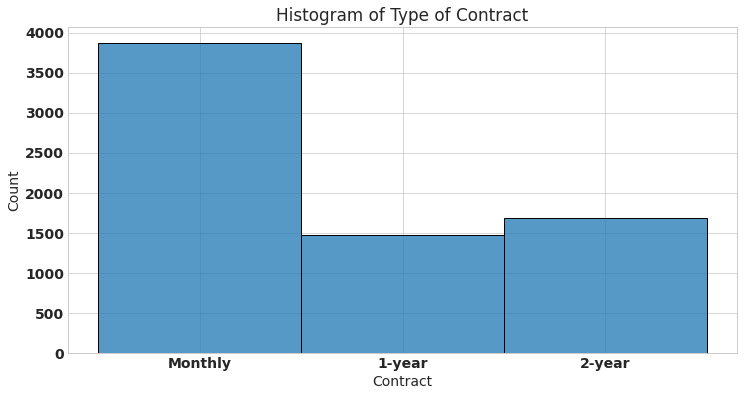

In [662]:
# Plotting histogram of type of contract

sns.histplot(x=df['Contract'], bins=3)
plt.title('Histogram of Type of Contract')
plt.xticks(ticks=(0,1,2), labels=['Monthly','1-year', '2-year'])
plt.show()

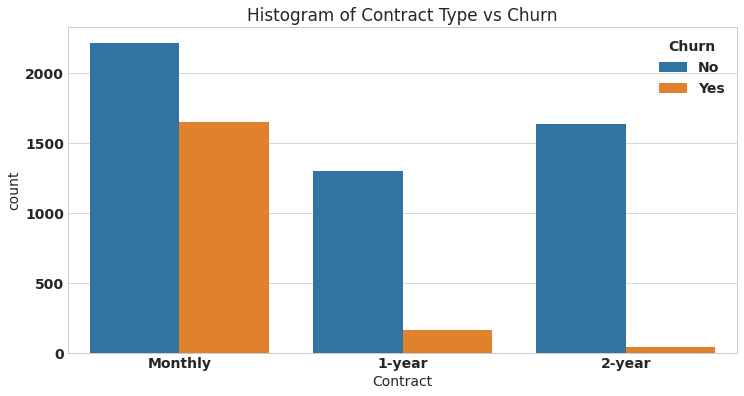

In [663]:
# Plotting contract type with churn

sns.countplot(x='Contract', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Contract Type vs Churn')
plt.xticks(ticks=(0,1,2), labels=['Monthly','1-year', '2-year'])
plt.show()

Most of the people have a month-to-month payment system in place and these people clearly also decide to quit the service more often than those people who have 1-year or 1-year contracts. It is clear that we should be promoting these longer term memberships instead of a monthly subscription.

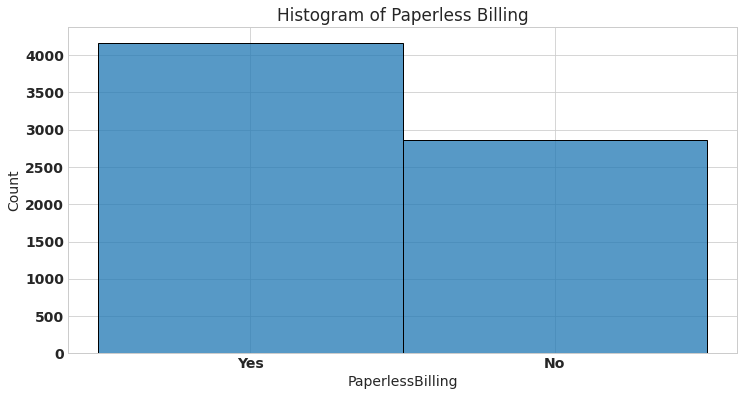

In [664]:
# Plotting histogram of type of contract

sns.histplot(x=df['PaperlessBilling'], bins=2)
plt.title('Histogram of Paperless Billing')
plt.show()

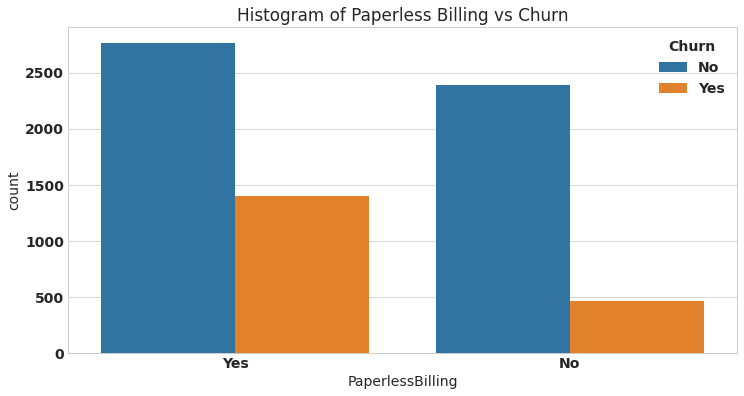

In [665]:
# Plotting paperless billing with churn

sns.countplot(x='PaperlessBilling', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Paperless Billing vs Churn')
plt.show()

The majority of the customers use paperless billing and around half of the total seem to be quitting the subscription.

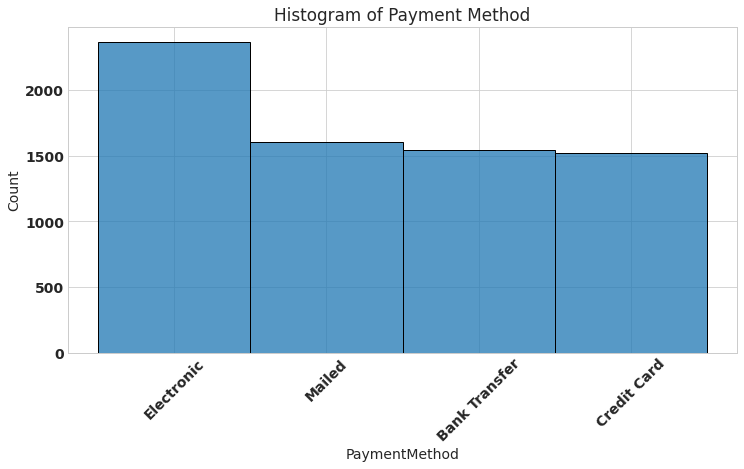

In [666]:
# Plotting histogram of payment method

sns.histplot(x=df['PaymentMethod'], bins=4)
plt.title('Histogram of Payment Method')
plt.xticks(ticks = (0,1,2,3), labels= ['Electronic', 'Mailed', 'Bank Transfer', 'Credit Card'], rotation=45)
plt.show()

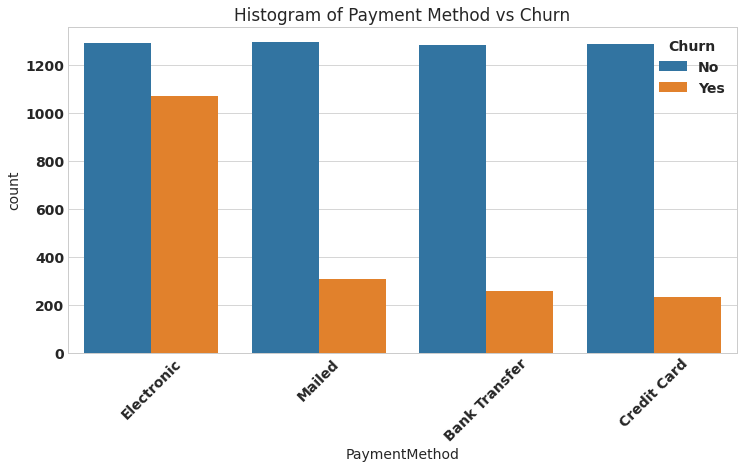

In [667]:
# Plotting paperless billing with churn

sns.countplot(x='PaymentMethod', data=df, hue='Churn', hue_order=['No','Yes'])
plt.title('Histogram of Payment Method vs Churn')
plt.xticks(ticks = (0,1,2,3), labels= ['Electronic', 'Mailed', 'Bank Transfer', 'Credit Card'], rotation=45)
plt.show()

Most of the customers use electronic checks as a way to pay the subscription and almost all of them decide to leave the service at some point.

We have now explored all the variables and seen that some of them seem to have a bigger effect on the churn than others. We are ready to proceed to feature engineering where we preprocess the data ready for modeling.

## 3. Feature Engineering

We will first change the categorical variables into numerical integers and scale the features i the same scale.  We will then check the correlation between the variables to help select the correct variables for modeling together with a chi-square test that provides a good way for feature selection when dealing with categorical variables.

In [830]:
# Checking dtypes of variables

df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [9]:
# Mapping features 

df['gender'] = df['gender'].map({'Male':1, 'Female':0}).astype(int)
df['Partner'] = df['Partner'].map({'Yes':1, 'No':0}).astype(int)
df['Dependents'] = df['Dependents'].map({'Yes':1, 'No':0}).astype(int)
df['PhoneService'] = df['PhoneService'].map({'Yes':1, 'No':0}).astype(int)
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes':1 ,'No':0}).astype(int)
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0}).astype(int)

df['MultipleLines'] = df['MultipleLines'].map({'Yes':1, 'No':0, 'No phone service':2}).astype(int)
df['InternetService'] = df['InternetService'].map({'Fiber optic':1, 'DSL':0, 'No':2}).astype(int)
df['OnlineSecurity'] = df['OnlineSecurity'].map({'Yes':1, 'No':0, 'No internet service':2}).astype(int)
df['OnlineBackup'] = df['OnlineBackup'].map({'Yes':1, 'No':0, 'No internet service':2}).astype(int)
df['DeviceProtection'] = df['DeviceProtection'].map({'Yes':1, 'No':0, 'No internet service':2}).astype(int)
df['TechSupport'] = df['TechSupport'].map({'Yes':1, 'No':0, 'No internet service':2}).astype(int)
df['StreamingTV'] = df['StreamingTV'].map({'Yes':1, 'No':0, 'No internet service':2}).astype(int)
df['StreamingMovies'] = df['StreamingMovies'].map({'Yes':1, 'No':0, 'No internet service':2}).astype(int)
df['Contract'] = df['Contract'].map({'Month-to-month':1, 'One year':0, 'Two year':2}).astype(int)
df['PaymentMethod'] = df['PaymentMethod'].map({'Electronic check':1, 'Mailed check':0, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3}).astype(int)

In [10]:
# Checking again dtypes

df.dtypes

customerID           object
gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService       int32
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract              int32
PaperlessBilling      int32
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges        float64
Churn                 int32
dtype: object

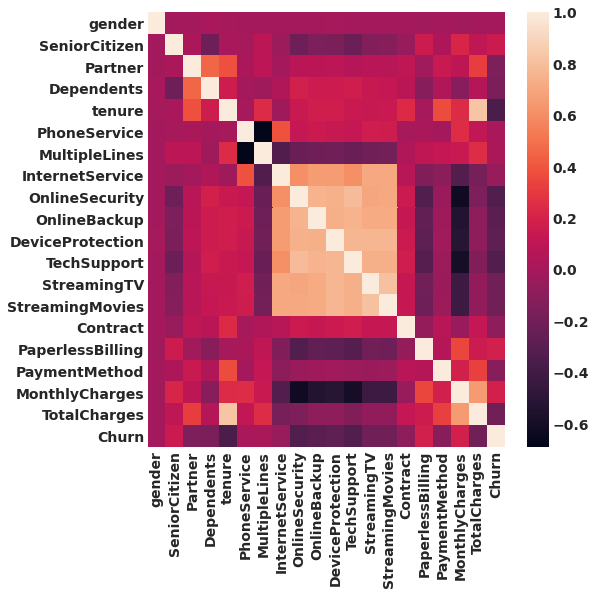

In [11]:
# Checking correlation between variables

plt.figure(figsize=(8,8))
sns.heatmap(df.corr())
plt.show()

We first check how the variables are correlated together. This means how a change in one of the variables affects a change in the other. 

From the heatmap we can see that most of the positively correlated variables appear in the middle of the matrix. These consist of the added features in the subscription package that the customers have or don't have such as internet service, online security, online backup, device protection, tech suppport, streaming tv and streaming movies. More or less the same people either have these features or they have none of them. Tenure also appears to be correlated with total charges. This makes sense as the longer you have been a customer, the higher the total costs of the service will be.

We can also notice the negative correlation between monthly charges and features such as online security, online backup, device protection, tech support and in a lesser extent streaming tv and streaming movies. The higher the charges a customer has, the less likely the customer is using these features. This could be an indication that the customer is able to provide these kind of services on its own. Having a phone service also correlates negatively with having multiple lines, so if you are using a phone you do not have multiple lines.

In general the variables should be correlated with the target variable (i.e. churn) but uncorrelated among themselves. Looking at the image we can see that churn doesn't seem to be very correlated with any of the variables in a large extent, but we can see a bit of correlation here and there so we should probably want to keep as many variables as possible for modeling. However, we could consider of dropping some of the more negatively correlated features with monthly charges, for example online security and tech support, and either phone service or multiple lines which show as black color on the heatmap. The postively correlated monthly and total charges, as well as tenure should also be considered.

In [12]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.298493,32.421786,0.903299,0.615330,0.872582,0.718857,0.777162,0.776166,0.722412,0.816695,0.820677,1.030290,0.592719,1.423777,64.798208,2283.300441,0.265785
std,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.655867,0.737271,0.796556,0.778188,0.778542,0.795571,0.762952,0.761287,0.669398,0.491363,1.064493,30.085974,2266.771362,0.441782
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,35.587500,401.450000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.350000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,89.862500,3794.737500,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


A closer look at the features shows that some of the features have a much wider range of values than others. Tenure, monthly charges and total charges need to be scaled into similar range with the other variables so we do that next. This could be done by standardizing the feature by removing the mean and scaling to unit variance or by scaling each feature to a given range. As most of the variables are in a binary form or have a maximum of 2, we will use the MinMaxScaler() from the `scikit-learn` library. The transformation is given by the formula:

$X_{std} = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))$

$X_{scaled} = X_{std} * (max - min) + min$

In [13]:
# Feature scaling

scaler = MinMaxScaler()

df['tenure'] = scaler.fit_transform(np.array(df['tenure']).reshape(-1,1))
df['MonthlyCharges'] = scaler.fit_transform(np.array(df['MonthlyCharges']).reshape(-1,1))
df['TotalCharges'] = scaler.fit_transform(np.array(df['TotalCharges']).reshape(-1,1))

In [14]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.298493,0.442560,0.903299,0.615330,0.872582,0.718857,0.777162,0.776166,0.722412,0.816695,0.820677,1.030290,0.592719,1.423777,0.463166,0.261309,0.265785
std,0.500014,0.368844,0.499729,0.457629,0.345708,0.295571,0.655867,0.737271,0.796556,0.778188,0.778542,0.795571,0.762952,0.761287,0.669398,0.491363,1.064493,0.299363,0.261571,0.441782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.112676,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.172512,0.044155,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.394366,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.518408,0.159090,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.760563,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.712562,0.435719,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000


Now the features looked ready to be picked for modeling. So next we will do feature selection. Feature selection is the process of selecting a subset of the relevant features from the total features that will help to build eventually the models for predicting the churn. This will help to improve the accuracy of the models and reduce the risk of overfitting. There are a number of techniques this could be done so we will use two so that we can compare the results and make sure we make correct choices. The previous heatmap gives us an idea which could be the possible variables to be dropped. We start by checking features with a very high correlation between the features and dropping them.

<b> Feature Selection </b>

In [15]:
# Checking correlation of the features with a threshold

def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df, 0.8)
print('Correlated features: ', corr_features)

Correlated features:  {'TotalCharges', 'StreamingMovies'}


The total charges correlate highly with tenure and streaming movies with streaming tv so we begin by dropping these two features. We will also drop the customerID as it will not help with the classification task.

In [16]:
# Selecting features 

X = df.drop(['Churn','customerID', 'TotalCharges', 'StreamingMovies'], axis=1)
y = df['Churn'].values
X.shape, y.shape

((7032, 17), (7032,))

We have now 17 features and next we proceed to see the feature importances with the Random Forest algorithm. Random forests are one the most popular machine learning algorithms, because they provide in general a good predictive performance, and a combination of low overfitting and easy interpretability. We can easily see visually how importat each variable is contributing to the decision made in each tree. Moreover, the decision trees are built over a random extraction of the observations from the dataset and a random extraction of the features so because not every tree sees all the features or all the observations, this guarantees that the trees are de-correlated and therefore less prone to over-fitting.

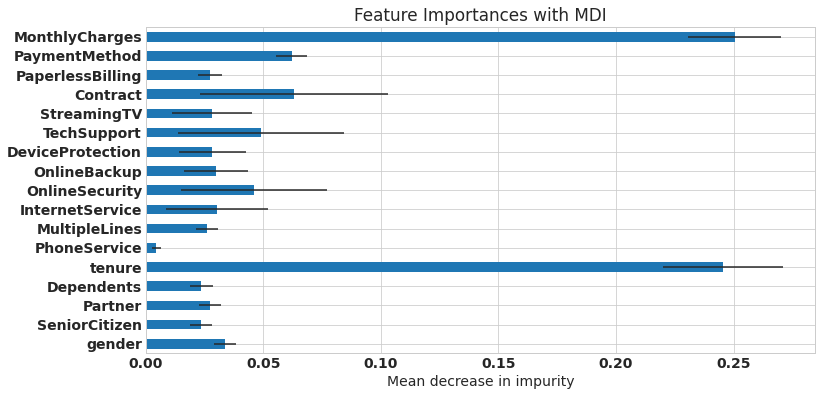

In [17]:
# Feature selection with random forest

rfc = RandomForestClassifier().fit(X,y)

feature_names = [f"{i}" for i in X.columns]
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot(xerr=std, ax=ax, kind='barh')
ax.set_title('Feature Importances with MDI')
ax.set_xlabel('Mean decrease in impurity')
plt.show()

For classification, we can measure the importance of each feature through measuring the information entropy with impurity by computing how much each feature decreases the impurity as an average across all the trees of the model. The more a feature decreases the impurity, the more important the feature will be. From the plot we can see that the highest decrease in impurity comes from monthly charges and tenure. Theese two features pretty much help explain the churn rate. On the other hand, the lowest decrease comes from phone service so can drop this feature, and keep all the other features as they seem to be contributing all at least a bit to the correct classification.

In [18]:
# Selecting features with random forest

X_df = df.drop(['Churn','customerID', 'TotalCharges', 'StreamingMovies', 'PhoneService'], axis=1)
X = np.array(X_df)
X.shape, y.shape

((7032, 16), (7032,))

After selecting the features we will perform a a stratified split of the dataset. This is what we took note in the beginning that we have a dataset that is unbalanced where the majority of the customers are those that want to stay within the service. This way make sure we have proportionally enough samples during training the models.

In [19]:
# Splitting data with stratified split

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5625, 16), (5625,), (1407, 16), (1407,))

## 4. Exploring Different Models

We are now ready to start modeling our data. We know that the dataset consisted of around 26.6 % of people that were indicated as leaving the service which means if we would predict everyone staying the accuracy would be 73.4 %. This is the baseline accuracy which we need to improve with our modeling. We will try six different models that use different techniques to classify churn. We will begin with Logistic Regression, Support Vector Machine (SVM) and Decision Tree Classifier which are frequently used in supervised classification problems. Then we will try two ensemble methods in the form of AdaBoost and Random Forest Classifier, before ending with the Naive Bayes model that makes classifications based on updating the probabilities with the Bayes' rule.  

In [20]:
# Modeling function to train and measure the results

def modeling(alg, alg_name, params={}):
    model = alg(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    def print_scores(alg, y_true, y_pred):
        print(alg_name)
        print("====" * 5)
        acc_score = accuracy_score(y_true, y_pred)
        print("Accuracy: %0.5f" % acc_score)
        pre_score = precision_score(y_true, y_pred)
        print("Precision: %0.5f" % pre_score)
        rec_score = recall_score(y_true, y_pred)                            
        print("Recall: %0.5f" % rec_score)
        f_score = f1_score(y_true, y_pred, average='weighted')
        print("F1 Score: %0.5f" % f_score)

    print_scores(alg, y_test, y_pred)
    return model

In [21]:
# Logistic Regression 

log_model = modeling(LogisticRegression, 'Logistic Regression')

Logistic Regression
Accuracy: 0.81023
Precision: 0.70189
Recall: 0.49733
F1 Score: 0.79880


In [22]:
# Support Vector Machine Classifier

svc_model = modeling(SVC, 'SVC Classification')

SVC Classification
Accuracy: 0.81521
Precision: 0.72441
Recall: 0.49198
F1 Score: 0.80263


In [23]:
# Decision Tree Classifier

dt_model = modeling(DecisionTreeClassifier, "Decision Tree")

Decision Tree
Accuracy: 0.72566
Precision: 0.48333
Recall: 0.46524
F1 Score: 0.72396


In [24]:
# Random Forest Classifier

rf_model = modeling(RandomForestClassifier, "Random Forest")

Random Forest
Accuracy: 0.79318
Precision: 0.65201
Recall: 0.47594
F1 Score: 0.78185


In [25]:
# AdaBoost Classifier

adaboost_model = modeling(AdaBoostClassifier, 'AdaBoost')

AdaBoost
Accuracy: 0.81166
Precision: 0.69258
Recall: 0.52406
F1 Score: 0.80259


In [26]:
# Gaussian Naive Bayes Classifier

nb_model = modeling(GaussianNB, "Gaussian Naive Bayes")

Gaussian Naive Bayes
Accuracy: 0.72708
Precision: 0.49167
Recall: 0.78877
F1 Score: 0.74198


In [27]:
# Confusion matrix of Support Vector Machine model

confusion_matrix(y_test, SVC().fit(X_train, y_train).predict(X_test))

array([[963,  70],
       [190, 184]], dtype=int64)

In [28]:
# Confusion matrix of Gaussian Naive Bayes model

confusion_matrix(y_test, GaussianNB().fit(X_train, y_train).predict(X_test))

array([[728, 305],
       [ 79, 295]], dtype=int64)

From the results of the models we can see that each model obtained very different results depending on what the focus of the metric was each time. The highest accuracy, where we managed to classify correctly those that were marked as churn and those that were marked as the opposite, was obtained with the Support Vector Machine (SVM) model and the highest Recall score (the score that we were interested of) with the Gaussian Naive Bayes model.

The confusion matrix is a matrix where on top we have first the true positives and then the false postives, and on the second row the false negatives and at the end the true negatives. From this matrix we can see that the SVM classifies better the true negatives (963 people who want to stay on the service) and has a lower score on the false positives (70 people who are classified wrong in wanting to leave the service but in fact want to stay). The Gaussian Naive Bayes on the other hand is better at classifying the true positives (295 people who want to leave) and has a lower rate in classifying false negatives (79 people who are classifed wrong in staying as they want to actually leave).

Next we will try to improve the Gaussian Naive Bayes model with some fine-tuning. We will first try different parameters for the model with GridSearchCV and use the recall score as a metric to tune the parameters. Afterwards, we will cross-validate the findings with RandomizedSearchCV in order to fine-tune for the best recall-accuracy.

## 5. Fine-Tuning the Best Model

In [75]:
# Hyperparameter tuning the Gaussian Naive Bayes model using GridSearchCV

scoring = make_scorer(recall_score)

param_grid = [
    {'var_smoothing': np.logspace(0, -9, num=100)},
]
gaussian_nb = GaussianNB()
grid_search = GridSearchCV(gaussian_nb, param_grid, cv=5, scoring=scoring, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .................var_smoothing=1.0;, score=0.729 total time=   0.0s
[CV 2/5] END .................var_smoothing=1.0;, score=0.773 total time=   0.0s
[CV 3/5] END .................var_smoothing=1.0;, score=0.783 total time=   0.0s
[CV 4/5] END .................var_smoothing=1.0;, score=0.779 total time=   0.0s
[CV 5/5] END .................var_smoothing=1.0;, score=0.749 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.8111308307896871;, score=0.766 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.8111308307896871;, score=0.816 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.8111308307896871;, score=0.823 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.8111308307896871;, score=0.806 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.8111308307896871;, score=0.789 total time=   0.0s
[CV 1/5] END ...var_smoothing=0.657933224657568;, score=0.803 total time=   0.0s
[CV 2/5] END ...var_smoothing=0.65793322465756

[CV 2/5] END ................var_smoothing=0.01;, score=0.829 total time=   0.0s
[CV 3/5] END ................var_smoothing=0.01;, score=0.839 total time=   0.0s
[CV 4/5] END ................var_smoothing=0.01;, score=0.803 total time=   0.0s
[CV 5/5] END ................var_smoothing=0.01;, score=0.786 total time=   0.0s
[CV 1/5] END var_smoothing=0.008111308307896872;, score=0.809 total time=   0.0s
[CV 2/5] END var_smoothing=0.008111308307896872;, score=0.829 total time=   0.0s
[CV 3/5] END var_smoothing=0.008111308307896872;, score=0.839 total time=   0.0s
[CV 4/5] END var_smoothing=0.008111308307896872;, score=0.803 total time=   0.0s
[CV 5/5] END var_smoothing=0.008111308307896872;, score=0.783 total time=   0.0s
[CV 1/5] END var_smoothing=0.006579332246575682;, score=0.809 total time=   0.0s
[CV 2/5] END var_smoothing=0.006579332246575682;, score=0.829 total time=   0.0s
[CV 3/5] END var_smoothing=0.006579332246575682;, score=0.836 total time=   0.0s
[CV 4/5] END var_smoothing=0

[CV 5/5] END var_smoothing=6.579332246575683e-05;, score=0.776 total time=   0.0s
[CV 1/5] END var_smoothing=5.3366992312063123e-05;, score=0.806 total time=   0.0s
[CV 2/5] END var_smoothing=5.3366992312063123e-05;, score=0.823 total time=   0.0s
[CV 3/5] END var_smoothing=5.3366992312063123e-05;, score=0.833 total time=   0.0s
[CV 4/5] END var_smoothing=5.3366992312063123e-05;, score=0.796 total time=   0.0s
[CV 5/5] END var_smoothing=5.3366992312063123e-05;, score=0.776 total time=   0.0s
[CV 1/5] END var_smoothing=4.328761281083062e-05;, score=0.806 total time=   0.0s
[CV 2/5] END var_smoothing=4.328761281083062e-05;, score=0.823 total time=   0.0s
[CV 3/5] END var_smoothing=4.328761281083062e-05;, score=0.833 total time=   0.0s
[CV 4/5] END var_smoothing=4.328761281083062e-05;, score=0.796 total time=   0.0s
[CV 5/5] END var_smoothing=4.328761281083062e-05;, score=0.776 total time=   0.0s
[CV 1/5] END var_smoothing=3.511191734215127e-05;, score=0.806 total time=   0.0s
[CV 2/5] EN

[CV 5/5] END var_smoothing=4.3287612810830526e-07;, score=0.776 total time=   0.0s
[CV 1/5] END var_smoothing=3.5111917342151277e-07;, score=0.806 total time=   0.0s
[CV 2/5] END var_smoothing=3.5111917342151277e-07;, score=0.823 total time=   0.0s
[CV 3/5] END var_smoothing=3.5111917342151277e-07;, score=0.833 total time=   0.0s
[CV 4/5] END var_smoothing=3.5111917342151277e-07;, score=0.796 total time=   0.0s
[CV 5/5] END var_smoothing=3.5111917342151277e-07;, score=0.776 total time=   0.0s
[CV 1/5] END var_smoothing=2.848035868435799e-07;, score=0.806 total time=   0.0s
[CV 2/5] END var_smoothing=2.848035868435799e-07;, score=0.823 total time=   0.0s
[CV 3/5] END var_smoothing=2.848035868435799e-07;, score=0.833 total time=   0.0s
[CV 4/5] END var_smoothing=2.848035868435799e-07;, score=0.796 total time=   0.0s
[CV 5/5] END var_smoothing=2.848035868435799e-07;, score=0.776 total time=   0.0s
[CV 1/5] END var_smoothing=2.310129700083158e-07;, score=0.806 total time=   0.0s
[CV 2/5] E

[CV 3/5] END var_smoothing=3.5111917342151273e-09;, score=0.833 total time=   0.0s
[CV 4/5] END var_smoothing=3.5111917342151273e-09;, score=0.796 total time=   0.0s
[CV 5/5] END var_smoothing=3.5111917342151273e-09;, score=0.776 total time=   0.0s
[CV 1/5] END var_smoothing=2.848035868435805e-09;, score=0.806 total time=   0.0s
[CV 2/5] END var_smoothing=2.848035868435805e-09;, score=0.823 total time=   0.0s
[CV 3/5] END var_smoothing=2.848035868435805e-09;, score=0.833 total time=   0.0s
[CV 4/5] END var_smoothing=2.848035868435805e-09;, score=0.796 total time=   0.0s
[CV 5/5] END var_smoothing=2.848035868435805e-09;, score=0.776 total time=   0.0s
[CV 1/5] END var_smoothing=2.310129700083158e-09;, score=0.806 total time=   0.0s
[CV 2/5] END var_smoothing=2.310129700083158e-09;, score=0.823 total time=   0.0s
[CV 3/5] END var_smoothing=2.310129700083158e-09;, score=0.833 total time=   0.0s
[CV 4/5] END var_smoothing=2.310129700083158e-09;, score=0.796 total time=   0.0s
[CV 5/5] END 

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid=[{'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])}],
             scoring=make_scorer(recall_score), verbose=3)

In [76]:
grid_search.best_params_

{'var_smoothing': 0.23101297000831597}

In [77]:
grid_search.best_score_

0.8548494983277592

In [89]:
# Hyperparameter tuning the Gaussian Naive Bayes with RandomizedSearchCV (to cross-validate results of GridSearchCV)

param_distribs = {
    'var_smoothing': stats.reciprocal.rvs(0.05, 0.5, size=10000) 
}

gaussian_nb = GaussianNB()
rnd_search = RandomizedSearchCV(gaussian_nb, param_distributions=param_distribs, n_iter=50, cv=5, scoring=scoring, verbose=3, random_state=42)
rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .var_smoothing=0.05544957215494846;, score=0.819 total time=   0.0s
[CV 2/5] END .var_smoothing=0.05544957215494846;, score=0.843 total time=   0.0s
[CV 3/5] END .var_smoothing=0.05544957215494846;, score=0.863 total time=   0.0s
[CV 4/5] END .var_smoothing=0.05544957215494846;, score=0.819 total time=   0.0s
[CV 5/5] END .var_smoothing=0.05544957215494846;, score=0.813 total time=   0.0s
[CV 1/5] END ..var_smoothing=0.1076084266165045;, score=0.836 total time=   0.0s
[CV 2/5] END ..var_smoothing=0.1076084266165045;, score=0.863 total time=   0.0s
[CV 3/5] END ..var_smoothing=0.1076084266165045;, score=0.870 total time=   0.0s
[CV 4/5] END ..var_smoothing=0.1076084266165045;, score=0.833 total time=   0.0s
[CV 5/5] END ..var_smoothing=0.1076084266165045;, score=0.836 total time=   0.0s
[CV 1/5] END .var_smoothing=0.25324938519834256;, score=0.843 total time=   0.0s
[CV 2/5] END .var_smoothing=0.25324938519834256

[CV 2/5] END .var_smoothing=0.09437353684383229;, score=0.860 total time=   0.0s
[CV 3/5] END .var_smoothing=0.09437353684383229;, score=0.870 total time=   0.0s
[CV 4/5] END .var_smoothing=0.09437353684383229;, score=0.829 total time=   0.0s
[CV 5/5] END .var_smoothing=0.09437353684383229;, score=0.826 total time=   0.0s
[CV 1/5] END .var_smoothing=0.15838191179163574;, score=0.836 total time=   0.0s
[CV 2/5] END .var_smoothing=0.15838191179163574;, score=0.863 total time=   0.0s
[CV 3/5] END .var_smoothing=0.15838191179163574;, score=0.870 total time=   0.0s
[CV 4/5] END .var_smoothing=0.15838191179163574;, score=0.846 total time=   0.0s
[CV 5/5] END .var_smoothing=0.15838191179163574;, score=0.839 total time=   0.0s
[CV 1/5] END .var_smoothing=0.06455744799140961;, score=0.823 total time=   0.0s
[CV 2/5] END .var_smoothing=0.06455744799140961;, score=0.846 total time=   0.0s
[CV 3/5] END .var_smoothing=0.06455744799140961;, score=0.870 total time=   0.0s
[CV 4/5] END .var_smoothing=

[CV 3/5] END .var_smoothing=0.06429549809798926;, score=0.870 total time=   0.0s
[CV 4/5] END .var_smoothing=0.06429549809798926;, score=0.823 total time=   0.0s
[CV 5/5] END .var_smoothing=0.06429549809798926;, score=0.813 total time=   0.0s
[CV 1/5] END .var_smoothing=0.15832637270284788;, score=0.836 total time=   0.0s
[CV 2/5] END .var_smoothing=0.15832637270284788;, score=0.863 total time=   0.0s
[CV 3/5] END .var_smoothing=0.15832637270284788;, score=0.870 total time=   0.0s
[CV 4/5] END .var_smoothing=0.15832637270284788;, score=0.846 total time=   0.0s
[CV 5/5] END .var_smoothing=0.15832637270284788;, score=0.839 total time=   0.0s
[CV 1/5] END .var_smoothing=0.35378426824904663;, score=0.839 total time=   0.0s
[CV 2/5] END .var_smoothing=0.35378426824904663;, score=0.853 total time=   0.0s
[CV 3/5] END .var_smoothing=0.35378426824904663;, score=0.866 total time=   0.0s
[CV 4/5] END .var_smoothing=0.35378426824904663;, score=0.849 total time=   0.0s
[CV 5/5] END .var_smoothing=

RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=50,
                   param_distributions={'var_smoothing': array([0.39698578, 0.22101016, 0.15126393, ..., 0.35762739, 0.39167069,
       0.05482951])},
                   random_state=42, scoring=make_scorer(recall_score),
                   verbose=3)

In [90]:
rnd_search.best_params_

{'var_smoothing': 0.25324938519834256}

In [91]:
rnd_search.best_score_

0.8548494983277592

After doing some fine-tuning we manage to improve the Recall accuracy from 78.9 % to 85.5 %. This means, we are able to find 85 people out of 100 that are about to leave the subscription service.

## 6. Drawing Conclusions

In the beginning the goal was set to predict as many people as possible that were on the verge of leaving the subscription service. Our dataset had 7032 customers from which 1869 were indicated as churn. If we would have offered every customer a lower subscription fee in the future, we would have gained some money, but at the same time lost an even greater amount of the profits, because the majority (5168) of the customers had indicated to stay as subscribers. However, by classifying the customers with a Gaussian Naive Bayes, we were able to classify corretly 85.5 % of the total number of customers who were indicated to leave the service. With this accuracy, we are able to save on average €399,428 (1869*0.8548*0.5*500) of the revenues which we would have lost otherwise.